In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from toymodel import GeoUnit, ToyModel

The questions we want to ask:
   * How does the variance of a district's population depend on the whether we stay within the spine vs off?
   
Note: A pretty significant known drawback of this toy analysis is that the assumption that blocks have equal population though is very far from the truth. Actually, ~40% of the blocks in all of the US had 0 population in 2010.

In [2]:
def get_district_errors_at_block_level(toy, p, tract_name):
    """ Returns the error at of a district that is built by taking `p`
        percent of blocks from every block group from the tract `tract_name`.
        
        The error of the district is the sum of the errors of the blocks it is comprised of.
        Note: this sum allows cancellation and is not the sum of absolute errors.
        
        Args:
            toy       : ToyModel object 
            p         : Float [0,1], representing the proportion of 
                        blocks to sample from each block group
            tract_name: String, unique identifier of the tract
    """
    
    # retrieve all block groups of the tract
    dist_blocks = []
    tract = toy.get_node(tract_name)
    block_groups = toy.children(tract.identifier)

    # from each block group, sample `p` blocks
    for bg in block_groups:
        blocks = toy.children(bg.identifier)
        chosen_blocks = np.random.choice(blocks, int(p * len(blocks)), replace=False)
        dist_blocks.extend(chosen_blocks)

    raw_errors = [blk.data.error for blk in dist_blocks]    
    return sum(raw_errors)

def get_district_errors_at_bg_level(toy, p, tract_name):
    """ Returns the error at of a district that is built by taking `p` block groups from 
        the tract `tract_name`.
        
        The error of the district is the sum of the errors of the block groups it is 
        comprised of.
        
        Note: this sum allows cancellation and is not the sum of absolute errors.
        
        Args:
            toy       : ToyModel object 
            p         : Float [0,1], representing the proportion of block_groups to sample
            tract_name: String, unique identifier of the tract
    """
    
    # retrieve all block groups of the tract
    dist_bgs = []
    tract = toy.get_node(tract_name)
    block_groups = toy.children(tract.identifier)

    # sample `p` block groups
    chosen_bgs = np.random.choice(block_groups, int(p * len(block_groups)), replace=False)

    raw_errors = [bg.data.error for bg in chosen_bgs]
    return sum(raw_errors)

Now this is true that the variance scales with the number of blocks in a tract. This is simply because we have more random variables to sum up, and the variance of the sum of independent random variables is the sum of the variance of the independent random variables.

In [3]:
# experiment vars
ps = np.linspace(0,1,21)
num_runs = 1000

# toy model setup
num_bg = 10
num_blocks = 20
block_pop = 100.
eps_budget = 1 
eps_splits = [np.inf, 0.5, 0.5] 

# setup the DataFrame where we will store our results
p_errs_df = pd.DataFrame(columns=ps)

# for each proportion `p` of blocks from each blockgroup, do `num_runs` runs and get the error of the district.
for p in ps:
    dist_errs = []
    for _ in range(num_runs):
        # build a new tree, and apply the ToyDP to it
        hierarchy = [("Tract", 1, num_bg * num_blocks * block_pop),
                     ("BG", num_bg, num_blocks * block_pop),
                     ("Block", num_blocks, block_pop)]
        toy = ToyModel(hierarchy, eps_budget, eps_splits)
        toy.noise_and_adjust()

        # collect district error
        dist_err = get_district_errors_at_block_level(toy, p, "Tract")
        dist_errs.append(dist_err)
    p_errs_df[p] = dist_errs    

In [4]:
# modify the column names to have 2 decimal places, for pretty graphs
p_errs_df.columns = ['%s' % float('%.2g' % col) for col in p_errs_df.columns]
p_errs_df

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0,0,-6.576646,0.764658,20.507065,-12.705966,-11.568750,-9.565099,11.245313,-12.753549,-34.634935,...,-21.325861,19.121480,-13.600774,-26.378873,-7.773195,-18.599758,-6.592463,0.480168,2.496957,1.506351e-12
1,0,0.855668,2.306660,-15.199768,3.813891,-23.861513,8.917662,-31.315930,-3.712873,-0.738187,...,-19.203277,7.104397,-11.440226,-20.983708,-6.546082,-19.819374,-16.135321,-3.348205,8.946848,-2.685852e-12
2,0,-2.987905,-15.508064,11.165370,-14.134928,-1.238662,-2.515622,-15.203434,8.782389,-14.230891,...,-12.937046,-26.763805,-21.458902,14.216259,-10.676541,-3.265665,-8.425430,0.789584,-10.231515,-4.547474e-13
3,0,9.101691,-3.874154,-1.672934,5.548399,5.016251,-9.695602,3.859224,25.562893,-11.254287,...,-24.750672,-15.221234,18.818827,5.852383,-9.017763,7.140819,-35.309003,11.900372,-8.031517,5.968559e-13
4,0,-12.122986,12.279038,28.597515,-20.573989,4.492957,17.429617,-67.607006,-6.200120,-19.950670,...,-14.353681,-7.155447,-23.958788,-26.018776,-24.064814,14.112275,-17.843548,-9.478457,-9.114478,-2.160050e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,-3.293872,1.362695,10.138196,-30.968181,3.186738,30.224861,-12.929329,-6.486012,-21.258408,...,0.309024,15.145508,-9.375863,-1.551234,28.300563,4.675750,-21.862582,-2.460346,-3.755886,-3.510081e-12
996,0,-2.830180,0.367809,-16.184352,-6.168511,-1.026770,-17.931471,21.908573,-12.250394,25.225425,...,-11.265040,28.388448,-5.075327,16.413908,9.226238,-4.197359,10.947758,-13.791032,0.168833,5.968559e-13
997,0,-0.282651,-17.117364,6.998042,-26.026429,-21.690995,14.806041,3.295703,3.325961,-3.757859,...,5.478931,10.385978,24.771196,-10.887998,11.411831,-22.987500,-11.647258,-4.943424,17.179403,7.815970e-13
998,0,10.466035,10.146473,4.124004,23.523869,-29.370894,-23.135404,-30.430650,1.059044,-14.381559,...,2.617798,-37.685457,-10.000617,15.727510,9.985418,12.690794,4.522085,-1.196584,6.697826,2.259526e-12


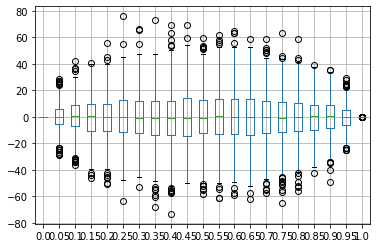

In [5]:
p_errs_df.boxplot()

In [6]:
# take the absolute value of the errors and plot.
for col in p_errs_df.columns:
    p_errs_df[col] = p_errs_df[col].abs()

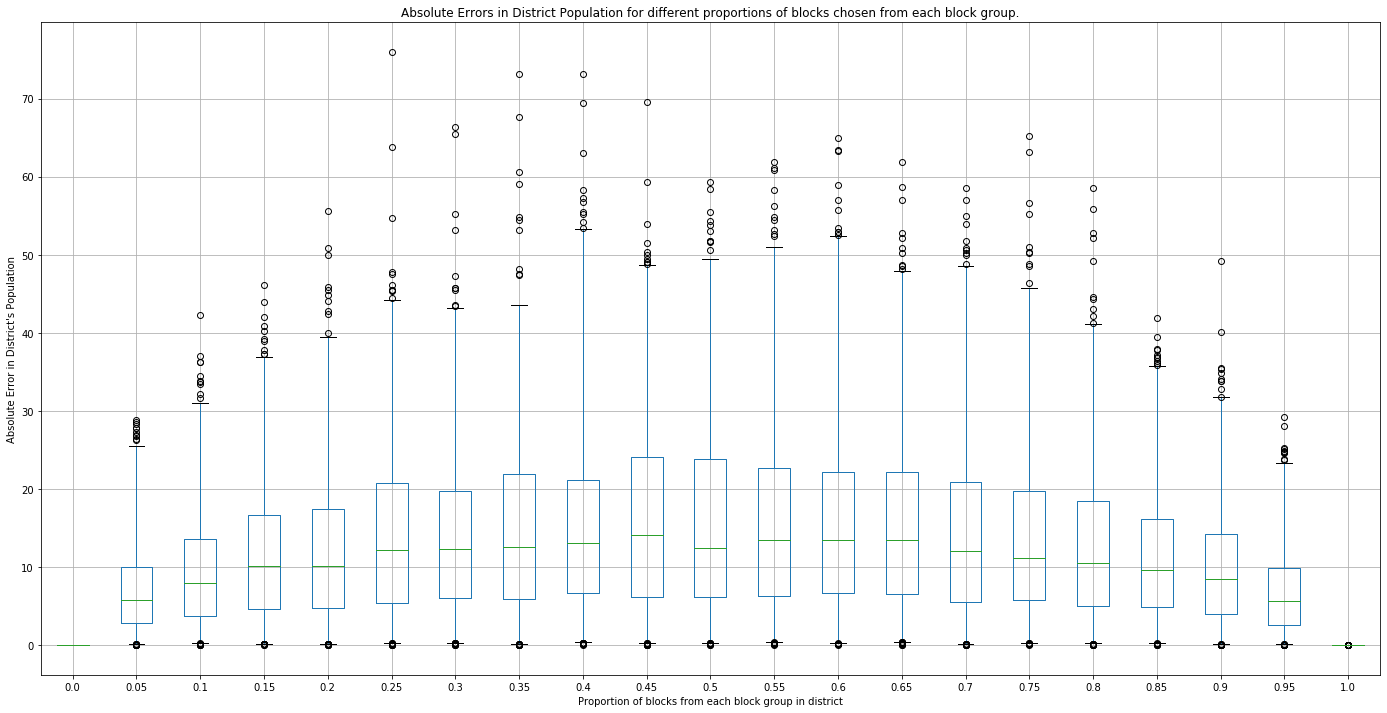

In [7]:
ax = plt.figure(figsize=(24,12))
p_errs_df.boxplot(whis=(1,99))
plt.xlabel("Proportion of blocks from each block group in district")
plt.ylabel("Absolute Error in District's Population")
plt.title("Absolute Errors in District Population for different proportions of blocks chosen from each block group.")
plt.show()

In the above figure, districts are made using *p* blocks from each block group in a tract. It is assumed that each district is nested completely inside the tract. Each boxplot represents 1000 points, and the whiskers are at the 1st and 99th percentile. I define a district's absolute error as:
                        $|\sum_{b \in B} E_{b}|$

For this setup, each tract has 10 block groups and each block group has 20 blocks. Each block has a population of 100. The epsilon budget is 1 and the Tree is 3 levels deep with a hierarchy of (Tract, BlockGroup, Block) and an epsilon split of (0, 0.5, 0.5).

**Things to note:**
* If you select 0 blocks from this tract, then your district has 0 blocks, so there is 0 error.
* The error peaks near p=0.5, as expected in Proposition 4.
* At p=1.0, all the blocks from all the block groups are chosen, so the entire tract is the district. For our toy setup, we have allocated a budget of 0 for our tracts so the error is 0, but if we had noised the tract then at p=1.0 we would have gotten the error at the tract instead of 0.
    
